In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
data_small = pd.read_csv('data\\small_data_shipped\\clean_data_small.csv', sep=',', engine='python')

In [3]:
data_small.columns

Index(['id', 'date_creat', 'nature', 'groupement', 'titre', 'titre_court',
       'objet', 'objet_social1', 'adrg_declarant', 'adrg_complemid',
       'adrg_complemgeo', 'adrg_libvoie', 'adrg_distrib', 'adrg_codepostal',
       'adrg_achemine', 'adrg_pays', 'objet_social1_desc'],
      dtype='object')

In [4]:
data_small[['adrg_declarant', 'adrg_complemid', 
            'adrg_complemgeo', 'adrg_libvoie', 
            'adrg_distrib', 'adrg_codepostal', 'adrg_achemine']].head()

,adrg_declarant,adrg_complemid,adrg_complemgeo,adrg_libvoie,adrg_distrib,adrg_codepostal,adrg_achemine
0,NaN,NaN,NaN,39 rue Courteline,NaN,69100,villeurbanne
1,NaN,NaN,NaN,18 rue AmpÃ¨re,NaN,69270,FONTAINE SUR SAONE
2,NaN,NaN,NaN,8 RUE EMMANUEL CHABRIER,NaN,03700,BELLERIVE-SUR-ALLIER
3,NaN,NaN,NaN,36 rue de la Roche du Geai,NaN,42000,Saint-Ã‰tienne
4,NaN,NaN,NaN,6 rue du BoispÃ©an,NaN,44110,ChÃ¢teaubriant


In [5]:
post_codes = data_small.adrg_codepostal

In [6]:
post_codes.head()

0    69100
1    69270
2    03700
3    42000
4    44110
Name: adrg_codepostal, dtype: object

In [7]:
strcount = 0
strings = []
fine = 0
count = Counter()

for index, row in post_codes.iteritems():
    try:
        tmp = str(int(float(row)))
        if len(tmp) == 5:
            fine += 1
            count[tmp] += 1  # Number of charities per postcode
        else:
            strcount += 1
    except ValueError:
        strcount += 1
        strings.append(row)

print(f'Fine: {fine}, Errors: {strcount}, NaNs (among errors): {post_codes.isna().sum()}')

Fine: 1441429, Errors: 89816, NaNs (among errors): 1854


In [8]:
geo_data = gpd.read_file('data/codes_postaux_V5/codes_postaux_region.shp')
geo_data = geo_data.set_index('ID')
num_charities = pd.DataFrame.from_dict(count, orient='Index')
geo_data['Num_Charities'] = num_charities

assert (~geo_data['Num_Charities'].isna()).sum() != 0

In [9]:
print(geo_data[['DEP', 'SURF', 'POP2010', 'Num_Charities']])

      DEP        SURF  POP2010  Num_Charities
ID                                           
26140  26   82.710226  12812.0          308.0
26150  26  315.349961   6301.0          487.0
26160  26  181.940199   7285.0          330.0
26300  26  236.697761  28064.0          605.0
26170  26  290.688573   5512.0          255.0
...    ..         ...      ...            ...
25960  25    8.261779    633.0           11.0
26110  26  380.058253  13950.0          509.0
26120  26  229.368202  21464.0          534.0
26130  26   77.966480  12133.0          314.0
91480  91   10.711169  10421.0          192.0

[6048 rows x 4 columns]


In [10]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# density = geo_data.Num_Charities/geo_data.POP2010

# density = density.where(np.isfinite(density), other=0)
# assert (~np.isfinite(density)).sum() == 0
# normalized = (density - density.min()) / (density.max() - density.min())

# geo_data.plot(column=(density), ax=ax, legend=True)

In [11]:
cities = Counter()

for index, row in post_codes.iteritems():
    try:
        float(row)
        cities[str(row)[:2]] += 1  # take the first two numbers which correspond to dept. code
    except ValueError:
        pass


In [12]:
geo_cities = geo_data.copy()
cities_charities = pd.DataFrame.from_dict(cities, orient='Index')
geo_cities = geo_cities.set_index('DEP')
geo_cities['Num_Charities'] = cities_charities
geo_cities = geo_cities.dissolve(by=geo_cities.index, aggfunc='sum')

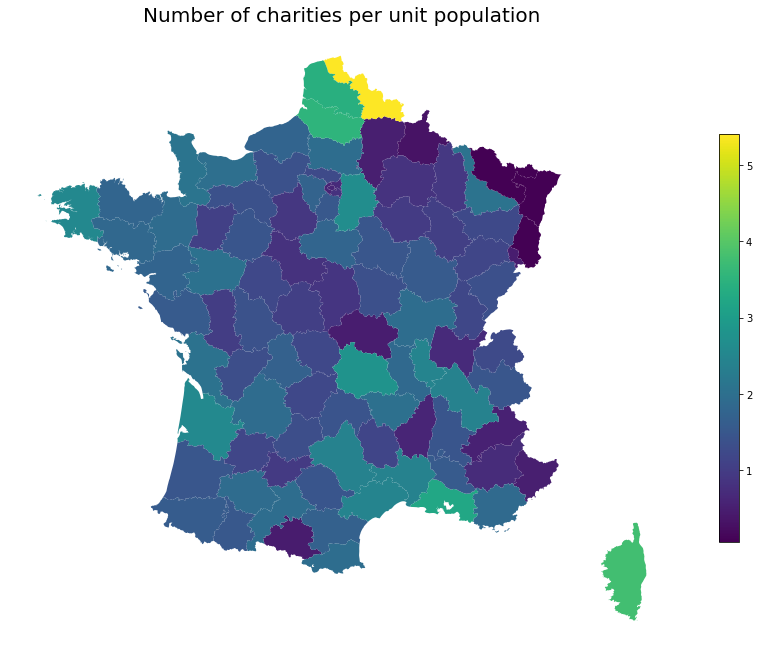

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

density = geo_cities.Num_Charities / geo_cities.POP2010
density = density.where(np.isfinite(density), other=0)

geo_cities.plot(column=(density), ax=ax, legend=True, legend_kwds={'shrink':0.5}) 
# legend_kwds take same arguments as matplotlib colorbars do

ax.set_axis_off()
ax.set_title('Number of charities per unit population', fontsize=20)

plt.savefig('graph')